In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import h5py
import einops
import time
import torch
import torchinfo
from pathlib import Path
device = torch.device("cpu")
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

In [2]:
sys.path.append('../')
from neuralnetwork.autoencoder import CAE
from neuralnetwork.preprocessing import normalize_data, train_valid_test_split
from neuralnetwork.earlystopping import EarlyStopper
from neuralnetwork.losses import LossTracker

#### 1 Data Import
1. Load the data
2. Discard the transient
3. Normalize and split the data

In [3]:
# Define some parameters for the data
ks_data = {
    'L': 22,
    'N_data': 200000,
    'N_trans': 1000,
    'dt': 0.2,
    'Nx': 512,
    'train_ratio': 0.5,
    'valid_ratio': 0.1,
    'batchsize': 128,
    'normtype': 'max', 
    'lyap':0.08
}


In [4]:
f = h5py.File('/storage0/eo821/KS/L22/M256_N512_tmax100000_deltat0.05L22.mat','r')
U = np.array(f.get('uu'))[:, 1000::4] 
U = einops.rearrange(U, 'x time-> time 1 x')
sysdim = U.shape[0]
print(f"Shape of KS data: {U.shape}")

# Normalize and split
U_normalized, maxnorm = normalize_data(U, normtype=ks_data['normtype'])
U_train_series, U_valid_series, U_test_series = train_valid_test_split(U_normalized, ks_data)

train_loader = torch.utils.data.DataLoader(torch.from_numpy(U_train_series).float(), batch_size=ks_data['batchsize'])
valid_loader = torch.utils.data.DataLoader(torch.from_numpy(U_valid_series).float(), batch_size=ks_data['batchsize'])

Shape of KS data: (499751, 1, 512)


#### 2 Convolutional Autoencoder
1. Load the class and set the number of latent variables
2. Train the CAE
3. (opt) Load pretrained weights

In [5]:
cae_model = CAE(8)
cae_model = cae_model.to(device)
print(torchinfo.summary(cae_model, input_size=(1, 1, ks_data['Nx'])))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cae_model.parameters(), lr=0.001)

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [1, 8]                    --
├─Sequential: 1-1                        [1, 8]                    --
│    └─Conv1d: 2-1                       [1, 2, 253]               18
│    └─Tanh: 2-2                         [1, 2, 253]               --
│    └─Conv1d: 2-3                       [1, 4, 123]               68
│    └─Tanh: 2-4                         [1, 4, 123]               --
│    └─Conv1d: 2-5                       [1, 8, 60]                168
│    └─Tanh: 2-6                         [1, 8, 60]                --
│    └─Conv1d: 2-7                       [1, 16, 19]               656
│    └─Tanh: 2-8                         [1, 16, 19]               --
│    └─Conv1d: 2-9                       [1, 32, 6]                1,568
│    └─Tanh: 2-10                        [1, 32, 6]                --
│    └─Conv1d: 2-11                      [1, 64, 2]                6,208
│    └─

In [6]:
# # Load model weights if available
# model_path = Path('/home/eo821/Documents/Kolmogorov-CAE-RNN/models/ks/L8pi/fluent-sweep-2')
# cae_model.load_state_dict(torch.load(model_path/"best_model.pth", map_location=device))
# cae_model = cae_model.to(device)

In [7]:
# Define the number of epochs and the gamma parameter for the scheduler
epochs = 10
gamma = 0.999

# Create an instance of ExponentialLR and associate it with your optimizer
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
loss_tracker = LossTracker(len(train_loader), len(valid_loader))

early_stopper = EarlyStopper(patience=200, min_delta=1e-6)
weighing_dissipation=1
cae_model =cae_model.to(device)
# wandb.watch(model)
best_model_state_dict = cae_model.state_dict()  # Save the best model state_dict
patience = 100
training_losses_per_epoch = []
validation_losses_per_epoch = []
best_validation_loss = float('inf')
for epoch in range(epochs):
    loss_tracker.set_start_time(time.time())
    loss_tracker.reset_current_loss()

    # Training loop
    cae_model.train()
    for step, x_batch_train in enumerate(train_loader):
        x_batch_train = x_batch_train.to(device)
        optimizer.zero_grad()
        encoded, output = cae_model(x_batch_train.to(device))
        loss = criterion(output, x_batch_train) 
        loss.backward()
        optimizer.step()
        loss_tracker.update_current_loss('training', loss)
    loss_tracker.print_current_loss(epoch, 'training')

    loss_tracker.set_start_time(time.time())
    scheduler.step()
    # Validation loop
    cae_model.eval()
    with torch.no_grad():
        for valid_step, x_batch_valid in enumerate(valid_loader):
            x_batch_valid = x_batch_valid.to(device)
            encoded, output = cae_model(x_batch_valid)
            loss = criterion(output, x_batch_valid) 
            loss_tracker.update_current_loss('validation', loss)
    
    loss_tracker.print_current_loss(epoch, 'validation')
    loss_tracker.calculate_and_store_average_losses()
        

    if loss_tracker.check_best_validation_loss():
        early_stopper.reset_counter()
        best_model_state_dict = cae_model.state_dict()  # the best model state_dict
        # torch.save(model.state_dict(), modelpath/'best_model.pth')  # Save the best model
        print('Saved best model')
    if early_stopper.track(loss_tracker.get_current_validation_loss()):
        break

In [ ]:
# model_path = Path('../weights/fluent-sweep-2')

# cae_model.load_state_dict(torch.load(model_path/"best_model.pth", map_location=device))
# cae_model = cae_model.to(device)

# # save the encoded data
# snapshot = torch.from_numpy(U_normalized).float()
# encoded, snapshot_decoded = cae_model(snapshot.to(device))
# with open('encoded_ks.npy', 'wb') as f:
#     np.save(f, encoded.detach().numpy())

#### 3 Plot the CAE results

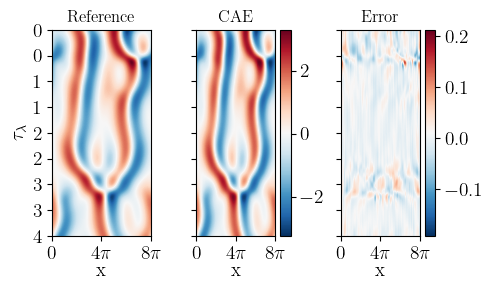

In [ ]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/ks_data["dt"])
N_plot = 5*N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length
domain_length = 8 * np.pi

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

# Encode and decode snapshot
snapshot = torch.from_numpy(U_test_series[:N_plot]).float()
encoded, snapshot_decoded = cae_model(snapshot.to(device))

maxnorm=3.58
# Extract data
data1 = snapshot.numpy(force=True)[:N_plot, 0, :] * maxnorm
data2 = snapshot_decoded.numpy(force=True)[:N_plot, 0, :] * maxnorm
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, ks_data["dt"])
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)
    
    # Add colorbar
    if i ==1 or i==2:
        cbar = fig.colorbar(im, ax=axes)
        cbar.ax.tick_params(labelsize=fs)
axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
plt.savefig("../images/cae.png", dpi=100)
